## Import libraries

In [263]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [265]:
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder, DecisionTreeEncoder, OrdinalEncoder
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.encoding import MeanEncoder
from feature_engine.selection import SelectByTargetMeanPerformance

In [168]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [169]:
pd.set_option('display.max_columns', None)

In [170]:
df = pd.read_csv('train.csv')

In [171]:
df.shape

(6495, 55)

## Drop columns

In [172]:
# Date time columns 
def preprocess_dates(df):
    now = dt.datetime.now()

    df['host_since'] = pd.to_datetime(df['host_since'])
    df['host_days'] = (now - df['host_since']).dt.days
    df.drop('host_since', axis=1, inplace=True)

    df['reviews_first'] = pd.to_datetime(df['reviews_first'])
    df['reviews_first'] = (now - df['reviews_first']).dt.days

    df['reviews_last'] = pd.to_datetime(df['reviews_last'])
    df['reviews_last'] = (now - df['reviews_last']).dt.days
    
    return df


preprocess_dates(df)

,property_id,property_name,property_summary,property_space,property_desc,property_neighborhood,property_notes,property_transit,property_access,property_interaction,property_rules,property_zipcode,property_lat,property_lon,property_type,property_room_type,property_max_guests,property_bathrooms,property_bedrooms,property_beds,property_bed_type,property_amenities,property_sqfeet,property_scraped_at,property_last_updated,host_id,host_location,host_about,host_response_time,host_response_rate,host_nr_listings,host_nr_listings_total,host_verified,booking_price_covers,booking_min_nights,booking_max_nights,booking_availability_30,booking_availability_60,booking_availability_90,booking_availability_365,booking_cancel_policy,reviews_num,reviews_first,reviews_last,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra,target,host_days
0,1,"Chambre à louer,courte durée.","Je loue une chambre dans mon appartement ""atyp...","Espace duplex très grand et lumineux,la chambr...","Je loue une chambre dans mon appartement ""atyp...",NaN,NaN,Accès direct de la Gare du Nord ( 4 arrêts de...,NaN,Je suis entièrement disponible pour tout échan...,NaN,NaN,50.858451,4.376594,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"Internet, Wireless Internet, Kitchen, Smoking ...",NaN,2017-05-08,a week ago,10012530,"Brussels, Brussels, Belgium",NaN,within a few hours,100.0,1.0,1.0,"email, phone, reviews",1,1,1125,7,37,67,96,flexible,23,2667.0,2150.0,97.0,10.0,9.0,10.0,10.0,9.0,10.0,1.31,Host Has Profile Pic,26,3414.0
1,2,Urban Antwerp - Spacious & Authentic Herenhouse,Our place is a typical historic herenhuis clos...,The spaces in our house are all large with hig...,Our place is a typical historic herenhuis clos...,Bar and restaurants One of our favourite bars ...,NaN,In Antwerp we have the system with rental bike...,You will be able to access the following space...,We are always available to help and assist whe...,NaN,2600,51.194744,4.413748,House,Entire home/apt,4,1.5,2.0,2.0,Real Bed,"TV, Cable TV, Wireless Internet, Kitchen, Brea...",NaN,2017-05-12,4 weeks ago,100188333,"Antwerp, Flanders, Belgium",NaN,within a few hours,75.0,1.0,1.0,"email, phone, reviews",1,2,15,0,0,25,25,flexible,1,2154.0,2154.0,100.0,10.0,10.0,10.0,10.0,8.0,10.0,1.00,"Host Has Profile Pic, Is Location Exact",75,2345.0
2,3,comfortable apartment in friendly neighborhood,Nice and cozy apartment for couples who like t...,Nice proper and clean apartment. No personal s...,Nice and cozy apartment for couples who like t...,Op 5 minuten lopen zijn er 2 gezellig stadpark...,Public transport is next to the apartment and ...,Fiets verhuur voor de deur. (dag/weekkaart) vi...,As a good host I trust my guest. No secrets an...,"Ik ben altijd bereikbaar voor vragen, maar ben...",NaN,2018,51.192501,4.409351,Condominium,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"Wireless Internet, Kitchen, Free parking on pr...",NaN,2017-05-12,2 days ago,100228761,"Antwerp, Flanders, Belgium",ik ben een expat die alleen mid weeks in Antwe...,within an hour,100.0,1.0,1.0,"email, phone, reviews",1,2,1125,20,34,55,330,flexible,4,2298.0,2144.0,93.0,10.0,10.0,9.0,9.0,9.0,10.0,0.75,"Host Has Profile Pic, Is Location Exact, Insta...",110,2345.0
3,4,Historical City Antwerp.,The best place to stay if you like to be in th...,Our rooms are nice and spacious. You stay in a...,The best place to stay if you like to be in th...,In the middle of the historical city of Antwerp,Staying in our house you have to be able to cl...,Tram 10 and 11 from Central station stop in ou...,Beside your own room you can relax in the down...,We will be available to let you know where wha...,Respectful towards other guest and host! No pets!,2000,51.220145,4.405446,House,Private room,2,1.0,1.0,1.0,Real Bed,"TV, Internet, Wireless Internet, Breakfast, He...",NaN,2017-05-12,5 weeks ago,10026319,Belgium,"Hello, I was born in the Netherlands and i sp...",within an hour,100.0,2.0,2.0,

In [173]:
# Columns where owners describe their properties

free_text_cols = ['property_name', 'property_summary', 'property_desc']

# Get columns with more than 30% missing values

missing_over_30 = df.columns[df.isnull().mean() > 0.3]
missing_over_30

Index(['property_space', 'property_neighborhood', 'property_notes',
       'property_transit', 'property_access', 'property_interaction',
       'property_rules', 'property_sqfeet', 'host_about'],
      dtype='object')

In [174]:
# Get the country of host location

df['host_location'] = df['host_location'].astype(str)

# Define a lambda function to extract the last element
last = lambda x: x.split(", ")[-1]

# Apply the lambda function 
countries = df['host_location'].apply(last)
countries = countries.replace('BE', 'Belgium')

# Top 10 countries of host location
countries.value_counts().sort_values(ascending=False).head(10)

Belgium           5854
France             212
Italy               51
US                  43
Spain               34
nan                 33
Netherlands         32
United States       23
United Kingdom      19
Germany             19
Name: host_location, dtype: int64

In [175]:
# Drop these columns out of both train and test sets
# Zip code is not necessary since we have longitude and latitude
# The date where data is scraped is of little importance 
# Drop booking_max_nights as many observations have value = 1125
# Drop host_location, host_verified, host_id, property_id since the variables are not informative 

cols_to_drop = free_text_cols + list(missing_over_30) + ["property_zipcode", "property_last_updated", "property_scraped_at", "booking_max_nights", "host_location", "host_verified", "host_id", "property_id"]

In [176]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [177]:
df.shape

(6495, 35)

In [335]:
# Make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in df.columns if df[var].dtype!='O' and var!='target' and df[var].nunique()<20]
continuous = [var for var in df.columns if df[var].dtype!='O' and var!='target' and var not in discrete]

# categorical
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 12 discrete variables
There are 16 continuous variables
There are 6 categorical variables


## Missing value imputation

### Categorical variables

In [179]:
# Check cardinality

df[categorical].nunique()

property_type              23
property_room_type          3
property_bed_type           5
property_amenities       6057
host_response_time          4
booking_cancel_policy       4
extra                      43
dtype: int64

In [180]:
# Check missing values

df[categorical].isnull().mean()

property_type            0.000000
property_room_type       0.000000
property_bed_type        0.000000
property_amenities       0.008006
host_response_time       0.224942
booking_cancel_policy    0.000000
extra                    0.000770
dtype: float64

In [181]:
# Extra column will indicate whether host is superhost
df['extra'] = df['extra'].astype(str).str.contains('Host Is Superhost').astype(int)

In [182]:
# Fill missing values

df['host_response_time'] = df['host_response_time'].fillna('Unknown')
df['property_amenities'] = df['property_amenities'].fillna('Unknown')

In [183]:
df[categorical].isnull().mean()

property_type            0.0
property_room_type       0.0
property_bed_type        0.0
property_amenities       0.0
host_response_time       0.0
booking_cancel_policy    0.0
extra                    0.0
dtype: float64

### Continuous variables

In [184]:
numeric = discrete + continuous
# Check missing values of discrete variables
df[numeric].isnull().mean()

property_max_guests         0.000000
property_bathrooms          0.001848
property_bedrooms           0.001386
property_beds               0.001694
booking_price_covers        0.000000
reviews_acc                 0.215396
reviews_cleanliness         0.215089
reviews_checkin             0.215704
reviews_communication       0.214935
reviews_location            0.216012
reviews_value               0.216320
property_lat                0.000000
property_lon                0.000000
host_response_rate          0.224942
host_nr_listings            0.000154
host_nr_listings_total      0.000154
booking_min_nights          0.000000
booking_availability_30     0.000000
booking_availability_60     0.000000
booking_availability_90     0.000000
booking_availability_365    0.000000
reviews_num                 0.000000
reviews_first               0.198614
reviews_last                0.198614
reviews_rating              0.212933
reviews_per_month           0.198614
target                      0.000000
h

In [252]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=7)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

X_train = train_df.drop('target',axis=1)
y_train = train_df['target']
X_val = val_df.drop('target',axis=1)
y_val = val_df['target']

In [253]:
# Impute median value 
median_imputer = MeanMedianImputer(imputation_method="median", 
                                   variables=["property_bathrooms", "property_bedrooms", "property_beds",
                                              "host_nr_listings", "host_nr_listings_total"])
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_val = median_imputer.transform(X_val)

In [334]:
# Column starts with "reviews"
reviews_cols = X_train.filter(regex='^reviews', axis=1).columns.to_list()

# Impute arbitrary value for the reviews variables
arbitrary_imputer = ArbitraryNumberImputer(arbitrary_number=0, 
                                           variables = reviews_cols + ['host_response_rate', 'host_days'])
arbitrary_imputer.fit(X_train)
X_train = arbitrary_imputer.transform(X_train)
X_val = arbitrary_imputer.transform(X_val)


In [255]:
# No missing value left

X_train.isnull().any().sum()

0

## Variables encoding

For `property_type`, there are many labels that rarely appear. We shall group all these labels together under the new category "Other_property_type"

In [189]:
df.groupby("property_type")['extra'].count() / len(df)

property_type
Apartment             0.764434
Bed & Breakfast       0.025558
Boat                  0.000154
Boutique hotel        0.000308
Cabin                 0.001078
Camper/RV             0.000154
Castle                0.000462
Chalet                0.000154
Condominium           0.012009
Dorm                  0.000308
Earth House           0.000154
Guest suite           0.000308
Guesthouse            0.005389
Hostel                0.000308
House                 0.136721
Loft                  0.026328
Other                 0.004619
Serviced apartment    0.000616
Tent                  0.000154
Timeshare             0.000154
Townhouse             0.017552
Villa                 0.002925
Yurt                  0.000154
Name: extra, dtype: float64

In [256]:
# Create a RareLabelEncoder object
rare_encoder = RareLabelEncoder(tol=0.007, n_categories=2, variables=['property_type'])

# Fit and transform the encoder 
X_train = rare_encoder.fit_transform(X_train)
X_val = rare_encoder.fit_transform(X_val)

In [257]:
X_train.property_type.unique()

array(['Apartment', 'House', 'Loft', 'Townhouse', 'Bed & Breakfast',
       'Rare', 'Condominium'], dtype=object)

In [258]:
# Create a dictionary to store the count of each amenity
amenities_count = {}

# Loop through the rows and count the amenities
for am_list in X_train['property_amenities'].astype(str):
    for am in am_list.split(', '):
        if am in amenities_count:
            amenities_count[am] += 1
        else:
            amenities_count[am] = 1

# Print the count of each amenity
for am, count in amenities_count.items():
    print(f"{am}: {count}")

TV: 2837
Wireless Internet: 4951
Kitchen: 4742
Smoking allowed: 825
Washer: 3021
Internet: 2966
Free parking on premises: 803
Doorman: 64
Breakfast: 608
Indoor fireplace: 322
Heating: 4949
Smoke detector: 3292
Carbon monoxide detector: 1093
First aid kit: 1273
Fire extinguisher: 1884
Essentials: 4537
Shampoo: 3009
Hair dryer: 2681
Iron: 2522
Laptop friendly workspace: 2618
translation missing: en.hosting_amenity_49: 1105
translation missing: en.hosting_amenity_50: 1419
Bed linens: 39
Extra pillows and blankets: 18
Wide doorway: 26
Accessible-height bed: 4
Safety card: 919
Hangers: 2908
Private entrance: 290
Wheelchair accessible: 349
Buzzer/wireless intercom: 1963
Family/kid friendly: 2860
Self Check-In: 232
Doorman Entry: 78
Pets allowed: 548
24-hour check-in: 1224
Cable TV: 1506
Suitable for events: 285
Elevator in building: 1509
Dryer: 1487
Air conditioning: 269
Lock on bedroom door: 738
Table corner guards: 5
Hot tub: 177
Keypad: 44
Gym: 89
Bathtub: 119
Game console: 15
Microwave: 

In [259]:
total_rows = len(X_train)

popular_amenities_count = {amenity: count for amenity, count in amenities_count.items() if count/total_rows > 0.25} # filter amenities that appear more than 30%
del(popular_amenities_count['translation missing: en.hosting_amenity_50'])
popular_amenities = list(popular_amenities_count.keys())
popular_amenities

['TV',
 'Wireless Internet',
 'Kitchen',
 'Washer',
 'Internet',
 'Heating',
 'Smoke detector',
 'Fire extinguisher',
 'Essentials',
 'Shampoo',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'Hangers',
 'Buzzer/wireless intercom',
 'Family/kid friendly',
 'Cable TV',
 'Elevator in building',
 'Dryer']

In [260]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the comma-separated values in 'property_amenities' column to a list of amenities
train_amenities = X_train['property_amenities'].astype(str).str.split(", ")
val_amenities = X_val['property_amenities'].astype(str).str.split(", ")

# Create an instance of MultiLabelBinarizer and fit it on the amenities list
mlb = MultiLabelBinarizer(classes=popular_amenities)
train_amenities = mlb.fit_transform(train_amenities)
val_amenities = mlb.transform(val_amenities)

# Create a new DataFrame with the one hot encoded columns
train_amenities = pd.DataFrame(train_amenities, columns=mlb.classes_)
val_amenities = pd.DataFrame(val_amenities, columns=mlb.classes_)

# Concat one hot encoded columns and drop the original columns
X_train = pd.concat([X_train, train_amenities], axis=1)
X_train.drop(columns="property_amenities", axis=1, inplace=True)

X_val = pd.concat([X_val, val_amenities], axis=1)
X_val.drop(columns="property_amenities", axis=1, inplace=True)

In [266]:
# set up the encoder
# encoder = DecisionTreeEncoder(
    #  variables=['property_type','property_room_type', 'property_bed_type', 
    #             'host_response_time','booking_cancel_policy'],
    #  regression=False,
    #  cv=3,
    #  random_state=0)

# One hot encode other categorical variables 
encoder = OneHotEncoder(
    variables = ['property_type','property_room_type', 'property_bed_type', 
                'host_response_time','booking_cancel_policy'],  
    drop_last=True,  
)

# fit the encoder
encoder.fit(X_train, y_train)
# transform the data
X_train = encoder.transform(X_train)
X_val = encoder.transform(X_val)


In [267]:
X_train.head(3)

,index,property_lat,property_lon,property_max_guests,property_bathrooms,property_bedrooms,property_beds,host_response_rate,host_nr_listings,host_nr_listings_total,booking_price_covers,booking_min_nights,booking_availability_30,booking_availability_60,booking_availability_90,booking_availability_365,reviews_num,reviews_first,reviews_last,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra,host_days,TV,Wireless Internet,Kitchen,Washer,Internet,Heating,Smoke detector,Fire extinguisher,Essentials,Shampoo,Hair dryer,Iron,Laptop friendly workspace,Hangers,Buzzer/wireless intercom,Family/kid friendly,Cable TV,Elevator in building,Dryer,property_type_Apartment,property_type_House,property_type_Loft,property_type_Townhouse,property_type_Bed & Breakfast,property_type_Rare,property_room_type_Entire home/apt,property_room_type_Private room,property_bed_type_Real Bed,property_bed_type_Pull-out Sofa,property_bed_type_Couch,property_bed_type_Futon,host_response_time_Unknown,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_within a day,booking_cancel_policy_flexible,booking_cancel_policy_strict,booking_cancel_policy_moderate
0,4056,50.821346,4.380675,4,1.0,2.0,1.0,0.0,1.0,1.0,1,6,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,2813.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1,5418,50.827112,4.372949,2,1.0,1.0,1.0,100.0,1.0,1.0,1,1,27,57,87,87,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,2619.0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2,377,50.864091,4.365768,1,1.0,1.0,1.0,100.0,1.0,1.0,1,1,15,23,36,36,25,2252.0,2149.0,89.0,9.0,9.0,9.0,10.0,9.0,9.0,6.76,0,2267.0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1


## Feature importance

In [268]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.iloc[:, 1:]), columns=X_train.columns[1:])
X_val = pd.DataFrame(scaler.transform(X_val.iloc[:, 1:]), columns=X_val.columns[1:])

In [269]:
sel_ = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=10))
sel_.fit(X_train, np.log(y_train))

SelectFromModel(estimator=RandomForestRegressor(random_state=10))

In [270]:
# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 66
selected features: 15


In [271]:
selected_feat

Index(['property_lat', 'property_lon', 'property_max_guests',
       'host_response_rate', 'booking_min_nights', 'booking_availability_30',
       'booking_availability_60', 'booking_availability_90',
       'booking_availability_365', 'reviews_num', 'reviews_first',
       'reviews_last', 'reviews_rating', 'reviews_per_month', 'host_days'],
      dtype='object')

In [302]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=50, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, random_state=0)

In [303]:
mse = mean_squared_error(regr.predict(X_train), y_train)
print(np.sqrt(mse))

19.480454435249943


In [304]:
mse = mean_squared_error(regr.predict(X_val), y_val)
print(np.sqrt(mse))

63.05098518068993


(array([ 38., 370., 431., 643., 495., 674., 611., 331., 432., 137., 235.,
        171.,  89., 103.,  37.,  72.,  58.,  61.,  29.,   6.,  23.,  18.,
         16.,   7.,  23.,   5.,   5.,   5.,   1.,   9.,  12.,   1.,   1.,
          1.,   4.,   0.,   9.,   0.,   0.,   8.,   1.,   1.,   0.,   3.,
          0.,   0.,   2.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   0.,
          1.,   1.,   0.,   1.,   0.,   2.,   2.,   1.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 10. ,  17.9,  25.8,  33.7,  41.6,  49.5,  57.4,  65.3,  73.2,
         81.1,  89. ,  96.9, 104.8, 112.7, 120.6, 128.5, 136.4, 144.3,
        152.2, 160.1, 168. , 175.9, 183.8, 191.7, 199.6, 207.5, 215.4,
        223.3, 231.2, 239.1, 247. , 254.9, 262.8, 270.7, 278.6, 286.5,
        294.4, 302.3, 310.2, 318.1

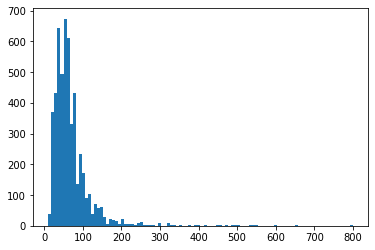

In [283]:
plt.hist(y_train, bins=100)

In [312]:
high = df[df.target > 150]

In [313]:
len(high)

275

In [322]:
categorical = ['property_type',
 'property_room_type',
 'property_bed_type',
 'host_response_time',
 'booking_cancel_policy']

In [325]:
for col in categorical:
    print(high[col].value_counts().head(5))

Apartment          213
House               37
Loft                11
Bed & Breakfast      6
Townhouse            3
Name: property_type, dtype: int64
Entire home/apt    185
Private room        86
Shared room          4
Name: property_room_type, dtype: int64
Real Bed         267
Pull-out Sofa      5
Couch              2
Futon              1
Name: property_bed_type, dtype: int64
within an hour        107
Unknown                70
within a few hours     50
within a day           43
a few days or more      5
Name: host_response_time, dtype: int64
flexible    125
moderate     84
strict       66
Name: booking_cancel_policy, dtype: int64


In [326]:
for col in categorical:
    print(df[col].value_counts().head(5))

Apartment          4965
House               888
Loft                171
Bed & Breakfast     166
Townhouse           114
Name: property_type, dtype: int64
Entire home/apt    4224
Private room       2187
Shared room          84
Name: property_room_type, dtype: int64
Real Bed         6281
Pull-out Sofa     151
Futon              35
Couch              23
Airbed              5
Name: property_bed_type, dtype: int64
within an hour        2462
Unknown               1461
within a few hours    1341
within a day          1033
a few days or more     198
Name: host_response_time, dtype: int64
flexible           2737
moderate           2004
strict             1753
super_strict_30       1
Name: booking_cancel_policy, dtype: int64


In [336]:
for col in continuous:
    print((col + ": {}").format(high[col].mean()))

property_lat: 50.89789048596913
property_lon: 4.369189296306403
host_response_rate: 93.06829268292682
host_nr_listings: 4.912727272727273
host_nr_listings_total: 4.912727272727273
booking_min_nights: 3.5527272727272727
booking_availability_30: 8.636363636363637
booking_availability_60: 21.04
booking_availability_90: 35.86545454545455
booking_availability_365: 160.9090909090909
reviews_num: 17.8
reviews_first: 2600.6296296296296
reviews_last: 2290.574074074074
reviews_rating: 92.23720930232558
reviews_per_month: 1.7835185185185192
host_days: 3087.309090909091


In [337]:
for col in continuous:
    print((col + ": {}").format(df[col].mean()))

property_lat: 50.90218559563823
property_lon: 4.37207015196437
host_response_rate: 92.06158124751688
host_nr_listings: 6.095934708962119
host_nr_listings_total: 6.095934708962119
booking_min_nights: 3.5319476520400306
booking_availability_30: 9.410931485758276
booking_availability_60: 22.650808314087758
booking_availability_90: 38.40431100846805
booking_availability_365: 171.84033872209392
reviews_num: 18.989068514241726
reviews_first: 2649.4249759846302
reviews_last: 2284.3454370797313
reviews_rating: 91.69287949921753
reviews_per_month: 1.6677118155619632
host_days: 3107.133199876809
